## Enabling Image Logging with RAY Actor Approach
Whylogs offers the flexibility of logging data related to images. This illustration showcases the integration of whylogs with image data.

Installing whylogs with Image Logging Support
For seamless image support, whylogs leverages Pillow. To enable whylogs with optional image support, follow these installation steps:

## Install whylogs with Image Logging Support
Whylogs uses [Pillow](https://python-pillow.org) for working with images. To install whylogs with the optional image support enabled, use the following:


In [48]:
# Note: you may need to restart the kernel to use updated packages.
%pip install 'whylogs[image,whylabs]'

Note: you may need to restart the kernel to use updated packages.


## Imports & Initialization

This section serves as the foundation of our analysis, where we import essential packages essential for data processing, machine learning model training, and performance evaluation. These meticulously selected tools empower us to seamlessly navigate the complexities of our task

In [49]:
import piexif
import random
import ray 
import ipyplot
import ray.data as df
from PIL import Image
import pandas as pd
import traceback
from typing import Dict
from PIL.ImageStat import Stat
import whylogs as why
from whylogs.extras.image_metric import log_image
from whylogs.core.datatypes import DataType
from whylogs.core.metrics import Metric
from whylogs.core.resolvers import StandardResolver
from whylogs.core.schema import DatasetSchema, ColumnSchema
from whylogs.extras.image_metric import ImageMetric, ImageMetricConfig


## Defining the Helper ImageResolver StandardResolver Class:
1. Elevating Image Logging to the Next Level
2. Our log_image() function offers a versatile interface for logging image data, enabling you to seamlessly integrate image logging with other data types.
3. To achieve this, we configure a custom DatasetSchema to identify columns containing images.
4. In this illustrative example, we extract and log key features from the images, incorporating them into a Pandas DataFrame.
5. By extending the StandardResolver class, we employ the ImageMetric for image columns while applying standard metrics to other columns.

In [50]:

class ImageResolver(StandardResolver):
    def resolve(self, name: str, why_type: DataType, column_schema: ColumnSchema) -> Dict[str, Metric]:
        print(name)
        print(why_type)
        print(column_schema)
        
        if "image" in name:
            return {ImageMetric.get_namespace(): ImageMetric.zero(column_schema.cfg)}
        return super(ImageResolver, self).resolve(name, why_type, column_schema)


## Crafting a RAY Actor Class with Distributed System Architecture for Enhanced Image Logging

1. Within this architectural framework, we introduce a RAY Actor class strategically designed to streamline the process of image logging, bolstering distributed system capabilities.

2. Our powerful log_image() function, encapsulated within this class, offers developers an intuitive and efficient means of image logging, ensuring seamless integration with the broader distributed system architecture

In [51]:
@ray.remote
class RayWhylogsImgBinProfileExpActor():
    
    def __init__(self):
        self.img1 = Image.effect_mandelbrot((256, 256), (-3, -2.5, 2, 2.5), 9)
        self.img2 = Image.effect_mandelbrot((256, 256), (-3, -2.5, 2, 2.5), 20)
        self._result = {}
        self._fractal_images = []
        self._cnt = 100
    
    '''
     @ description: 
     # The assuming that `generate_mandelbrot()` function provides a series of mandelbrot fractal image and structures for image analysis and processing experiment purpose.
    '''
    def generate_mandelbrot(self, width, height, x_min, y_min, x_max, y_max, iterations):
        try:
            for item in range(0, self._cnt):
                self._fractal_images.append(Image.effect_mandelbrot((width, height), (-int(random.randint(1.0,5.0)), 
                                                                                      -int(random.randint(1.0,5.0)), 
                                                                                      random.randint(1.0,5.0), 
                                                                                      random.randint(1.0,5.0)), iterations))
            return self._fractal_images
        except Exception as error:
            print(traceback.format_exc())
        
    '''
     @ description: 
     # The `log_image()` function provides a simple interface for logging images.
    '''
    def get_binary_data(self):
        try:
            display(self.img1)
            display(self.img2)
            results = log_image(self.img1)
            print("=*="*50)
            print(results.view().get_column("image").to_summary_dict())
            return self.img1,self.img2
        except Exception as error:
            print("Exception: get_binary_data", traceback.format_exc())
    
    '''
     @ description: 
     # On top of this remote actor function you can see, here just passing in an `Image` results in a column named "image" in the profile. 
     # You can pass in a list of images, which will append an index to each column name:
    '''
    def get_logged_column_dtls(self, lstmandelbrot: list):
        try:
            print("=*="*50)
            
            self._result = log_image(list(lstmandelbrot))
            schema = DatasetSchema(resolvers=ImageResolver(), default_configs=ImageMetricConfig())
            stats = Stat(lstmandelbrot[99])
            df = pd.DataFrame({"median": stats.median, "sum": stats.sum, "images": lstmandelbrot[99]})
            results = why.log(df, schema=schema).view()
            
            print("whyloged image columns::", results.get_column("median").to_summary_dict())
            print("whyloged image columns::", results.get_column("sum").to_summary_dict())
            print("whyloged image columns::", results.get_column("images").to_summary_dict())
            print("whyloged image columns::", list(self._result.view().get_columns()))
            print("whyloged image columns::", self._result.view().get_column("image_1").to_summary_dict())
            
            print("=*="*50)
            
            return self._result
        except Exception as error:
            print(traceback.format_exc())


## This karnel script is being run as the main program and it is being imported as a module into above script

In [56]:
def main_exp():
    try:
        # Create an instance of the RayWhylogsImgBinProfileExpActor
        objraywhylogsprf = RayWhylogsImgBinProfileExpActor.remote()
        
        lstmandelbrot = ray.get(objraywhylogsprf.generate_mandelbrot.remote(256, 256, -2.0, -1.5, 1.0, 1.5, 100))
        print("generated no.of images: =========", len(lstmandelbrot))
        ipyplot.plot_images(ray.get(objraywhylogsprf.generate_mandelbrot.remote(256, 256, -2.0, -1.5, 1.0, 1.5, 100)), max_images=100, img_width=75)

        #rmf:1
        # img1,img2 = ray.get(objraywhylogsprf.get_binary_data.remote())
        
        
        #rmf:2 
        ray.get(objraywhylogsprf.get_logged_column_dtls.remote(lstmandelbrot))
        

        ray.shutdown()
    except Exception as error:
        print(traceback.format_exc())

## This karnel script is being run as the main program and it is being imported as a module into above script

2023-09-22 18:23:26,806	INFO client_builder.py:237 -- Passing the following kwargs to ray.init() on the server: ignore_reinit_error
2023-09-22 18:23:26,810	INFO client_connect.py:37 -- Calling ray.init() again after it has already been called. Reusing the existing Ray client connection.


generated no.of images: ========= 100



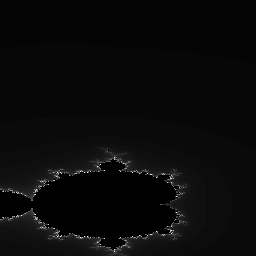
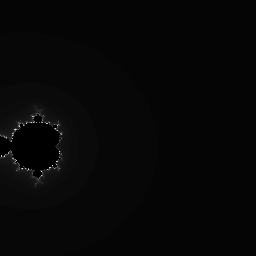
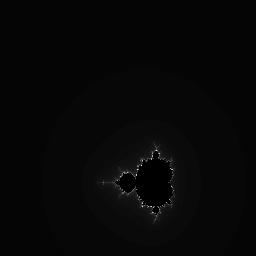
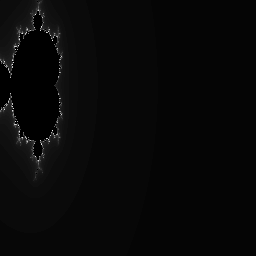
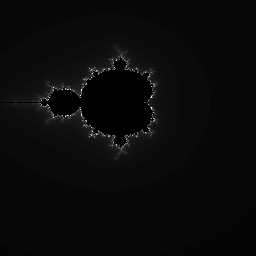
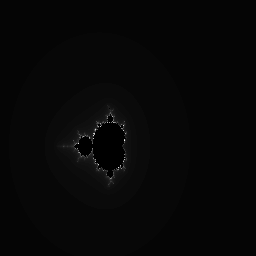
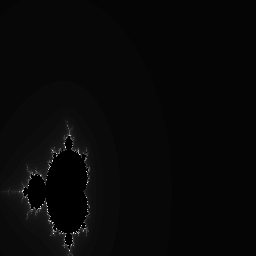
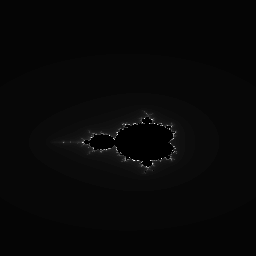
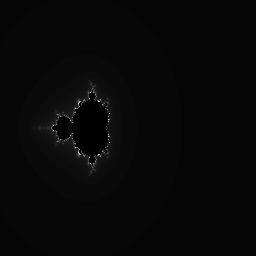
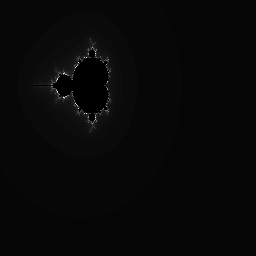
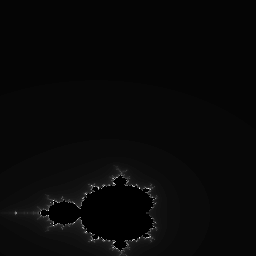
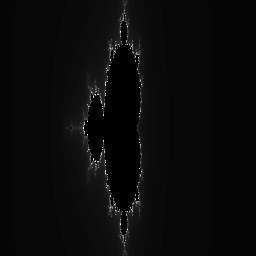
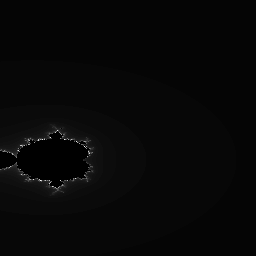
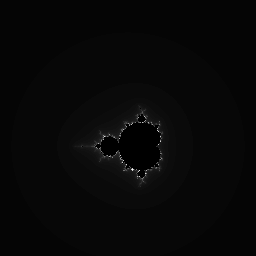
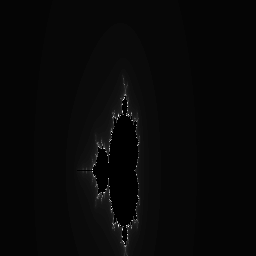
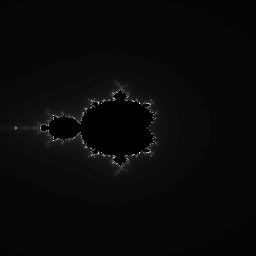
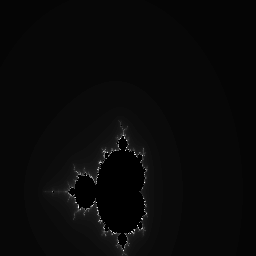
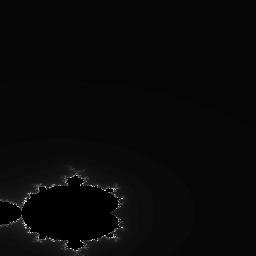
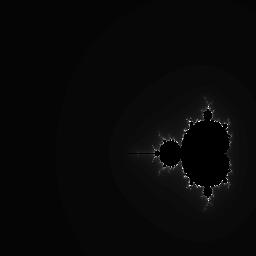
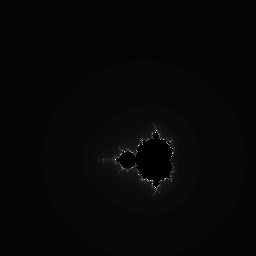
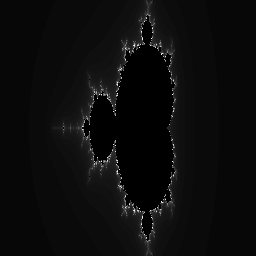
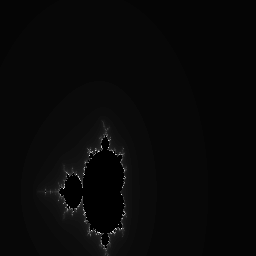
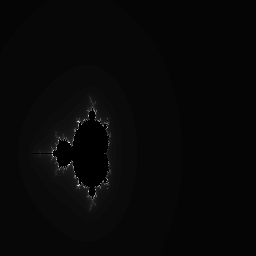
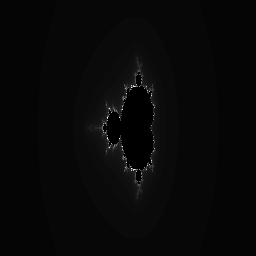
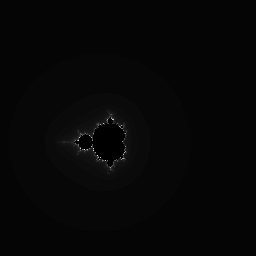
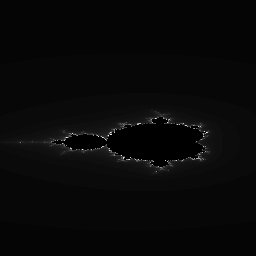
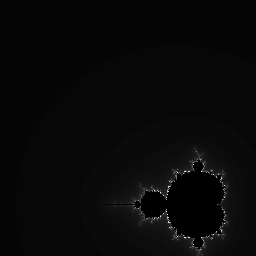
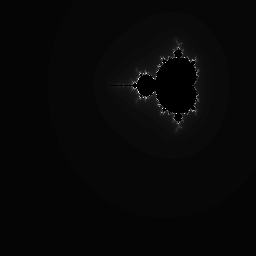
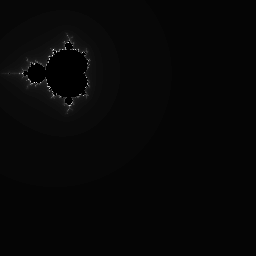
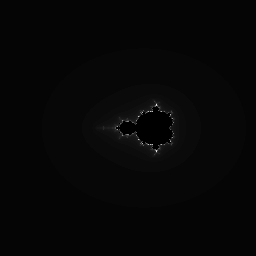
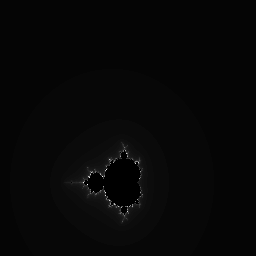
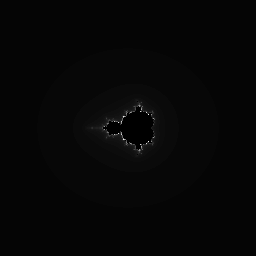
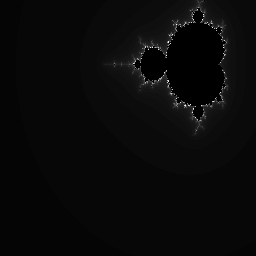
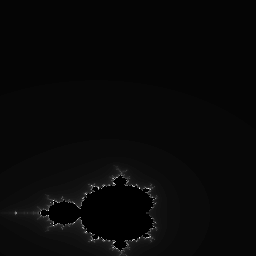
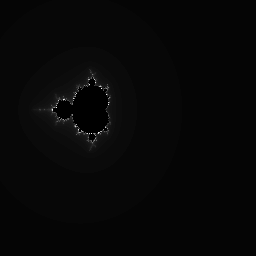
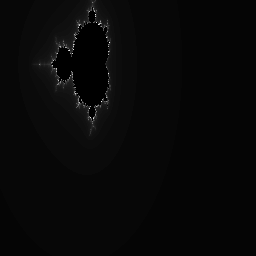
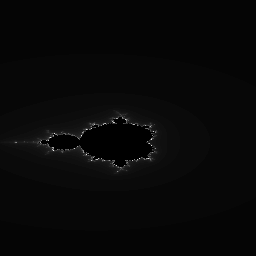
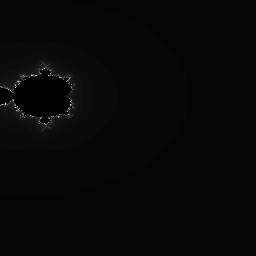
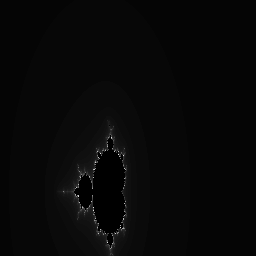
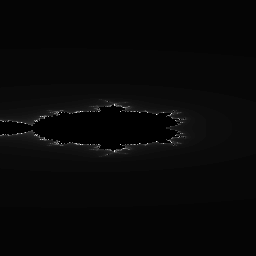
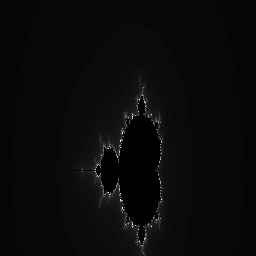
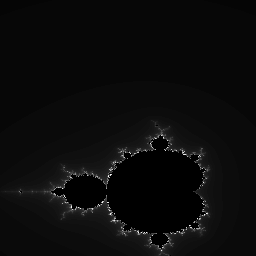
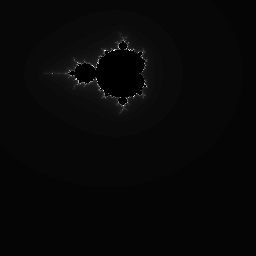
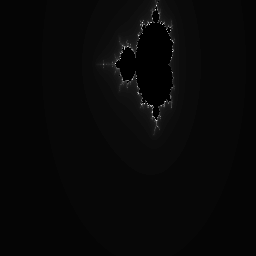
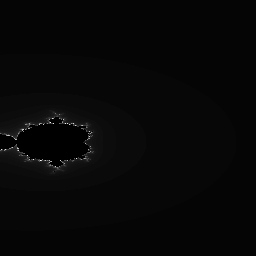
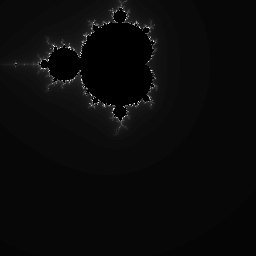
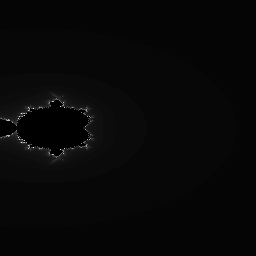
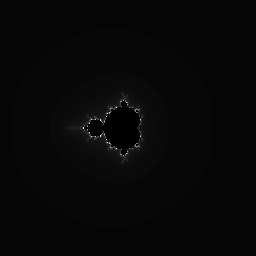
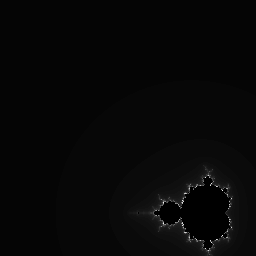
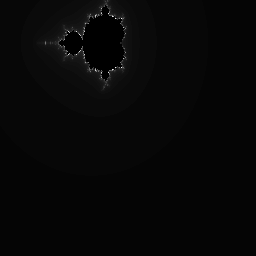
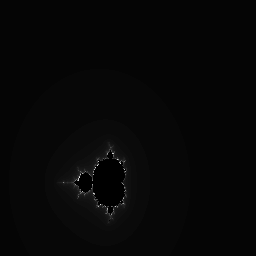
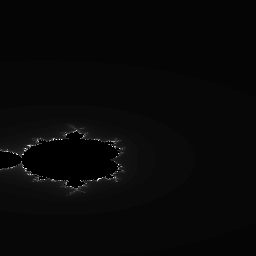
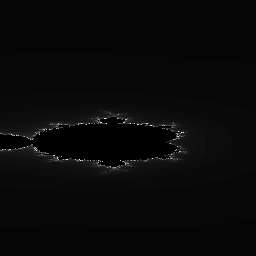
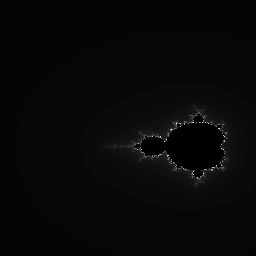
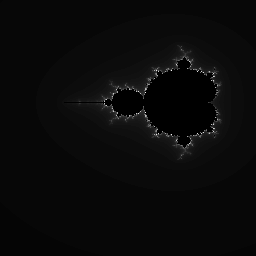
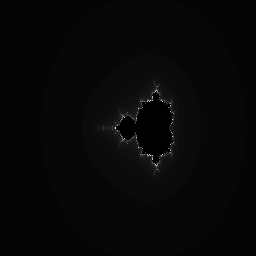
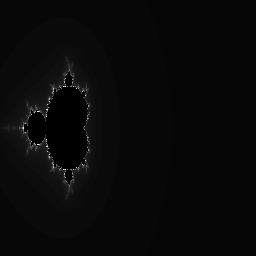
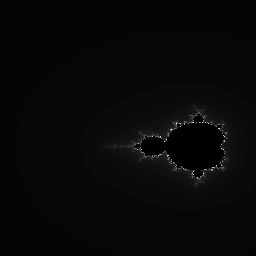
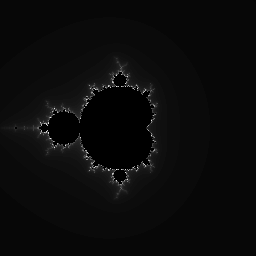
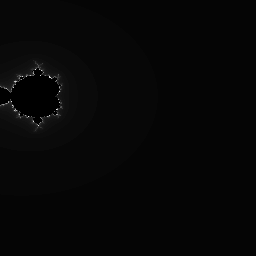
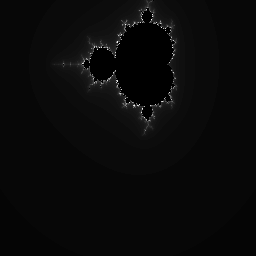
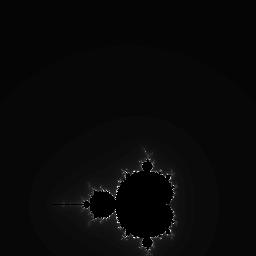
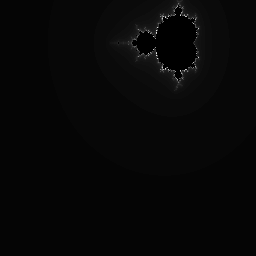
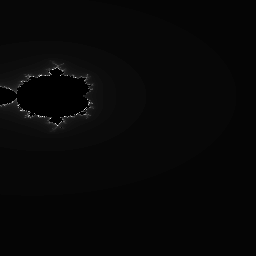
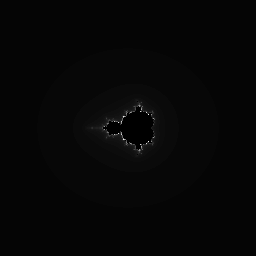
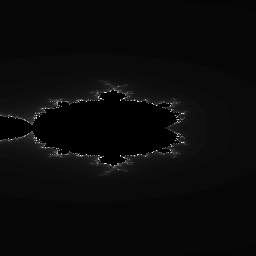
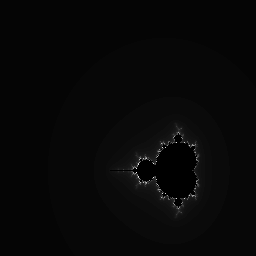
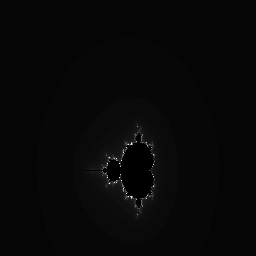
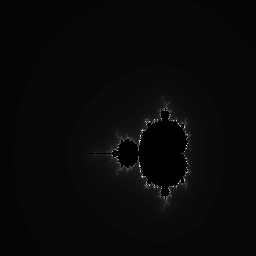
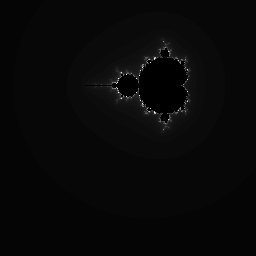
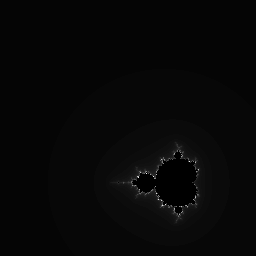
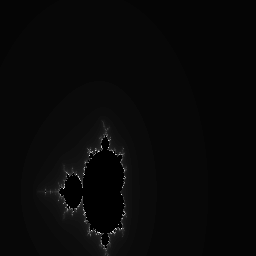
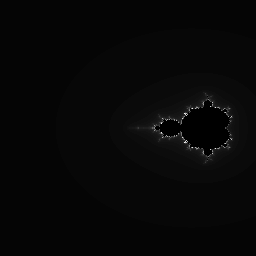
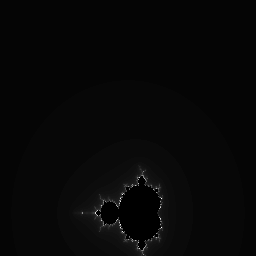
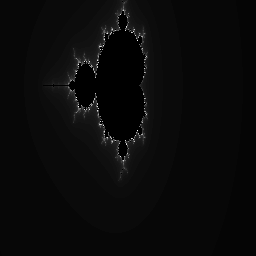
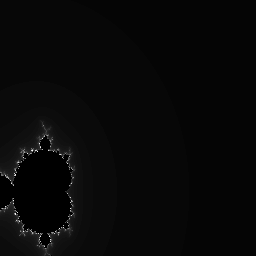
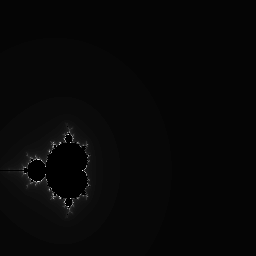
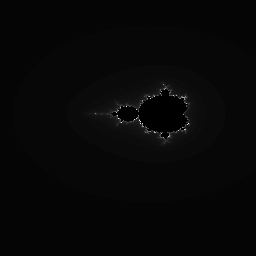
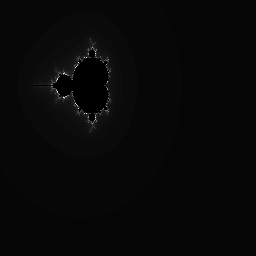
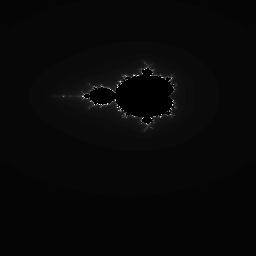
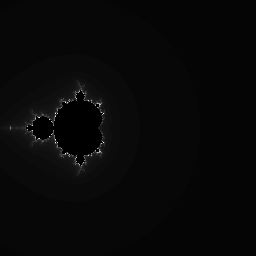
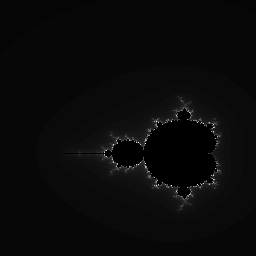
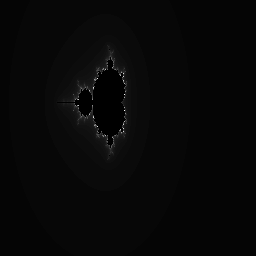
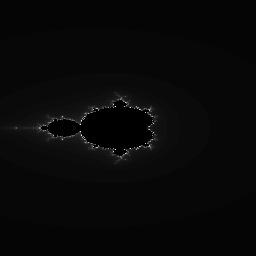
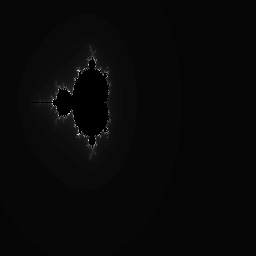
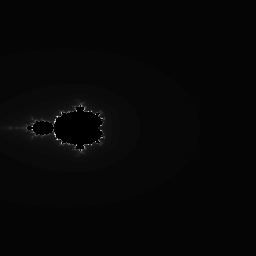
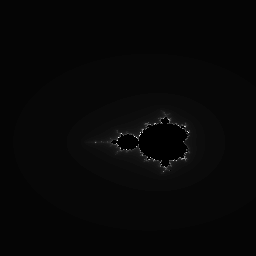
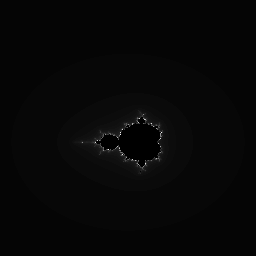
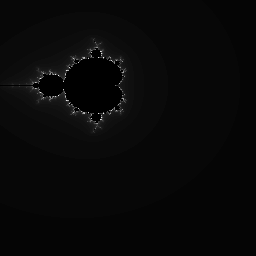
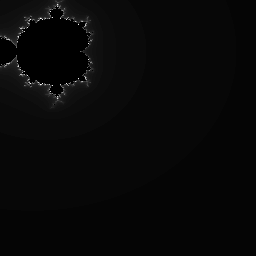
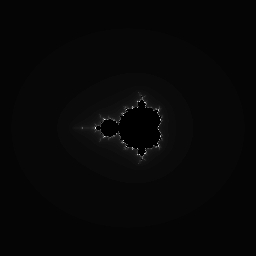
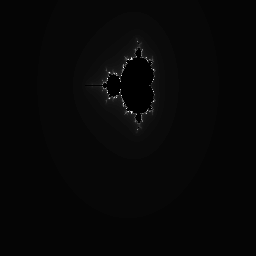
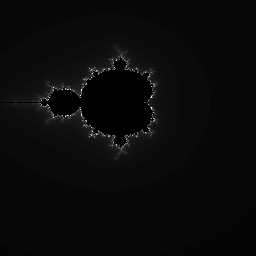
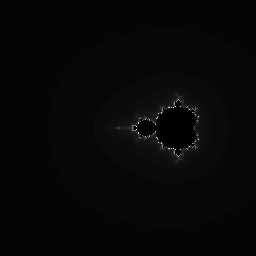
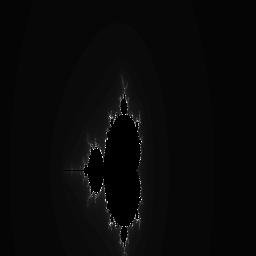
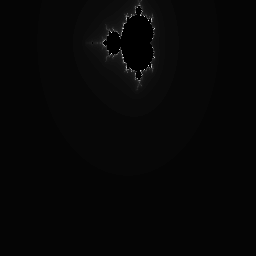
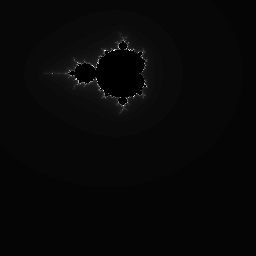
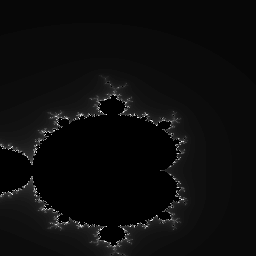
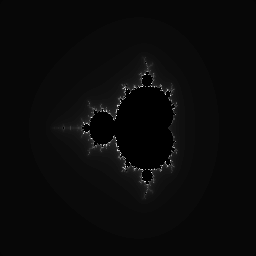
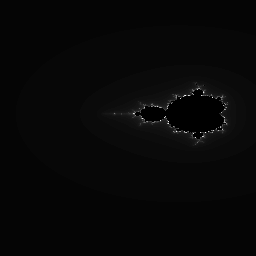


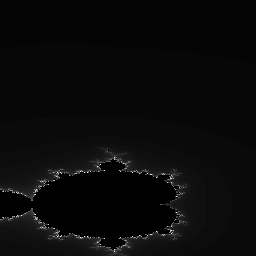
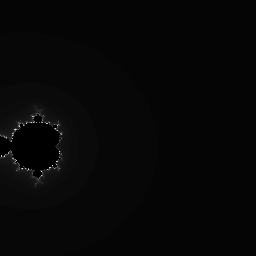
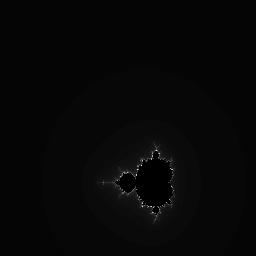
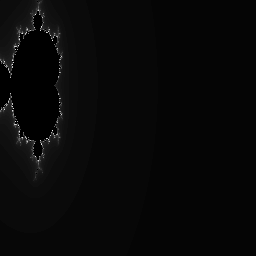
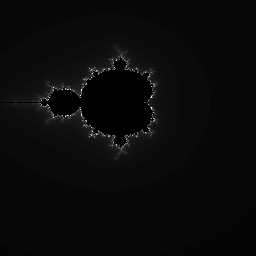
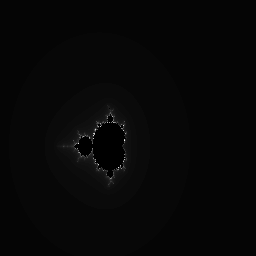
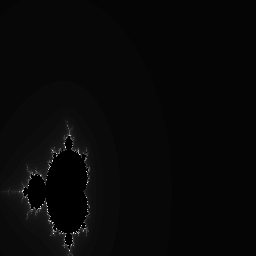
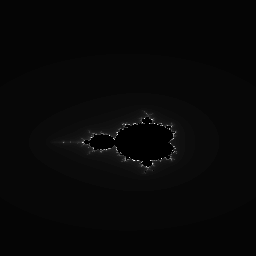
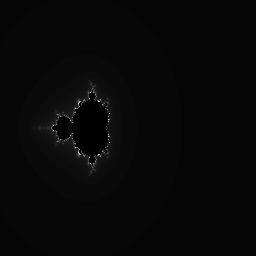
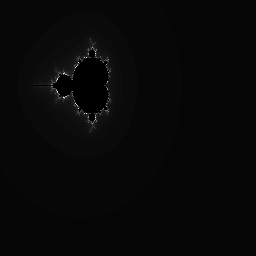
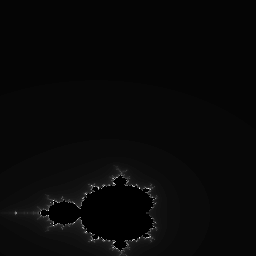
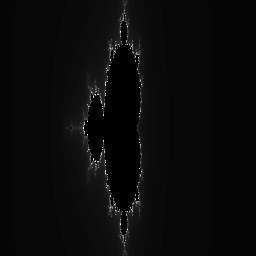
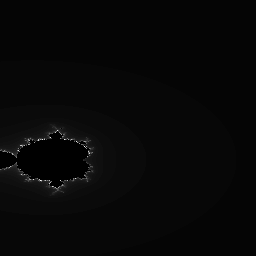
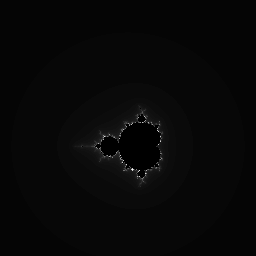
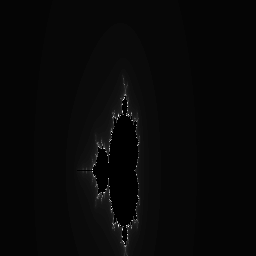
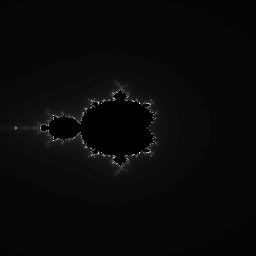
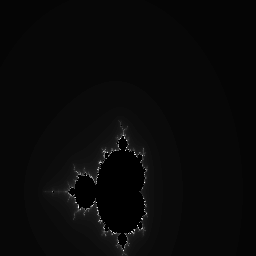
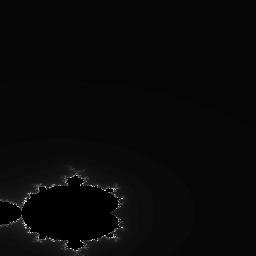
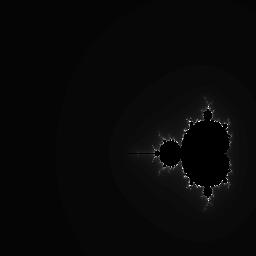
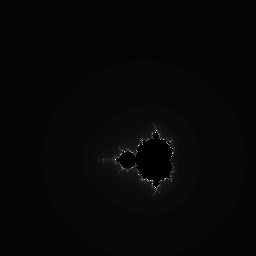
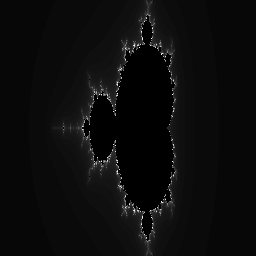
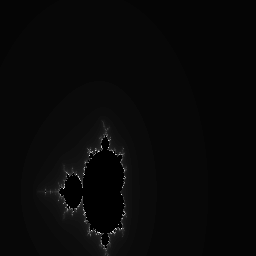
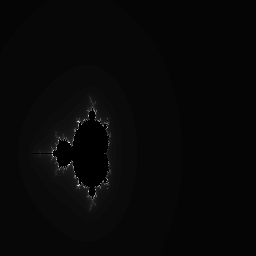
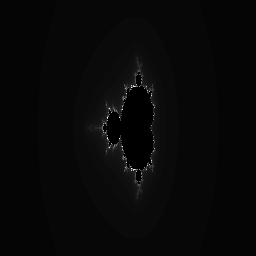
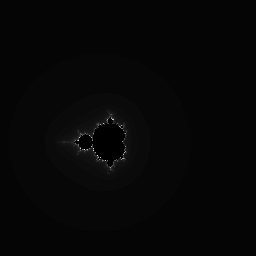
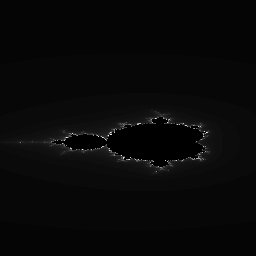
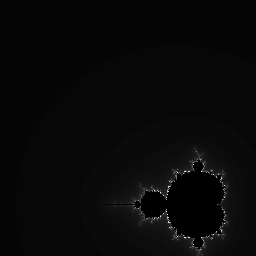
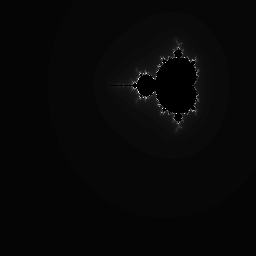
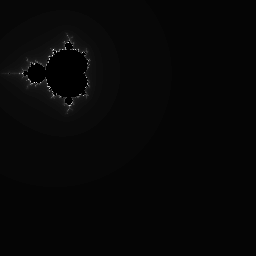
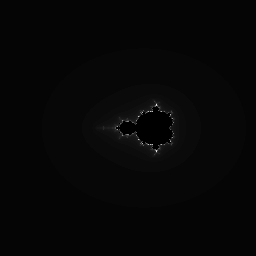
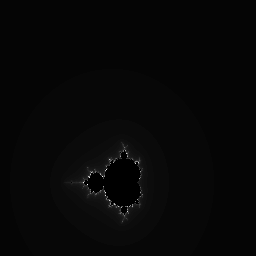
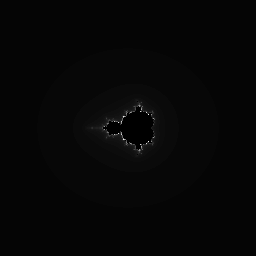
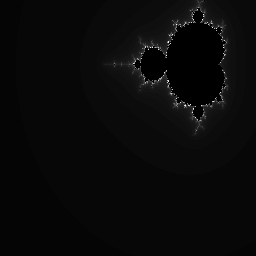
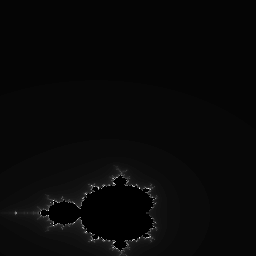
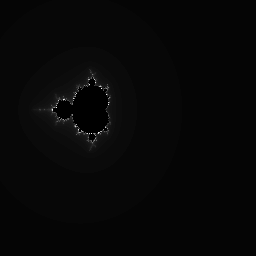
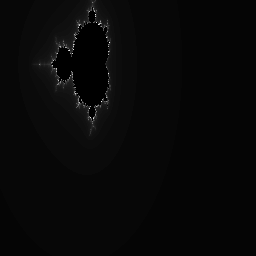
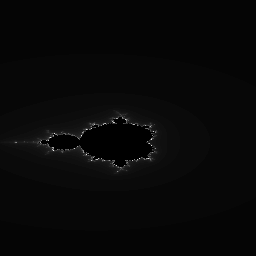
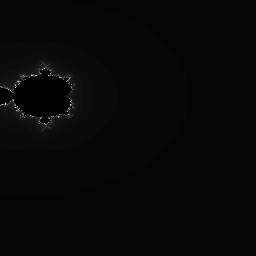
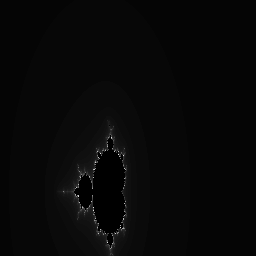
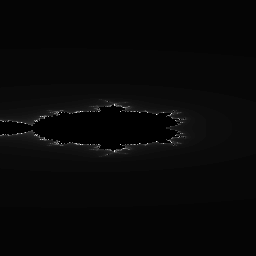
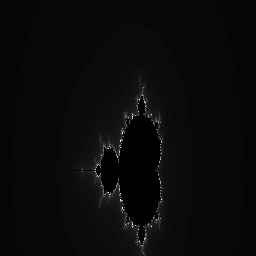
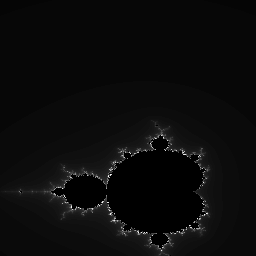
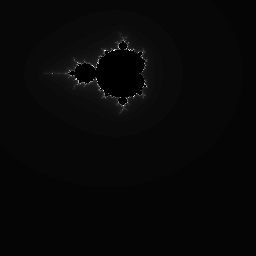
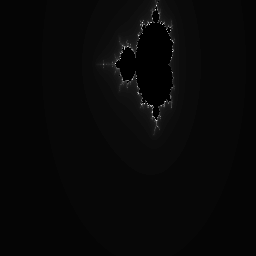
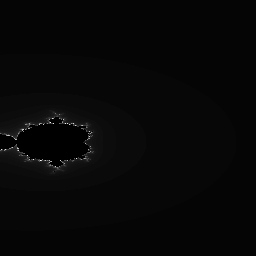
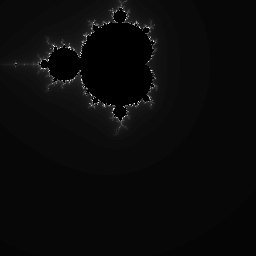
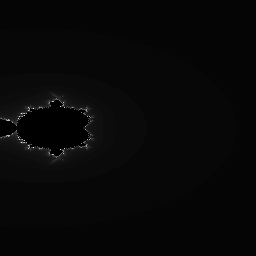
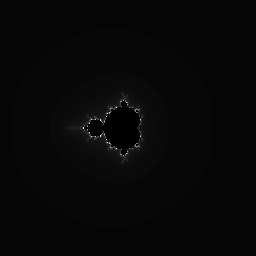
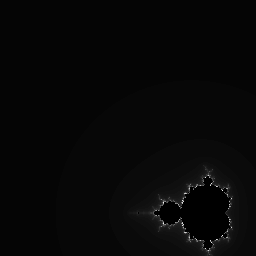
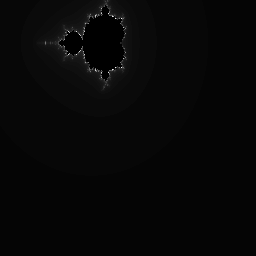
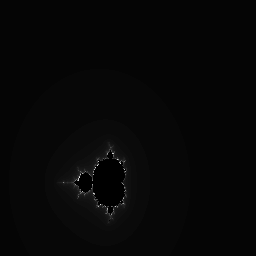
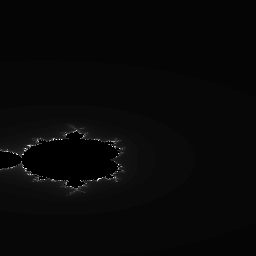
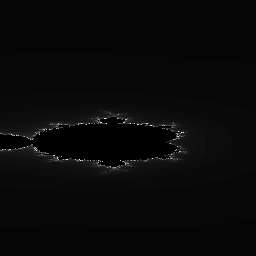
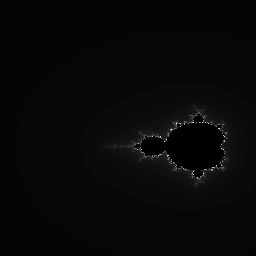
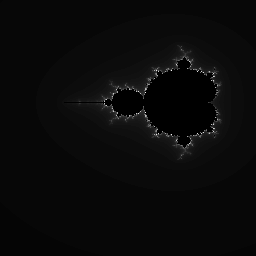
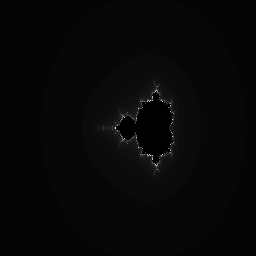
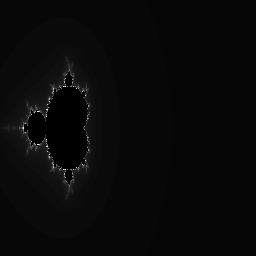
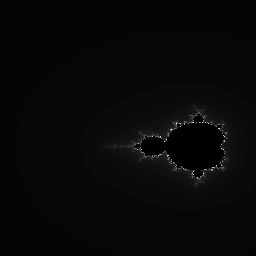
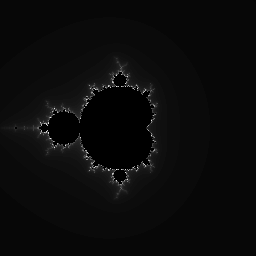
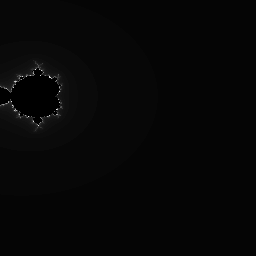
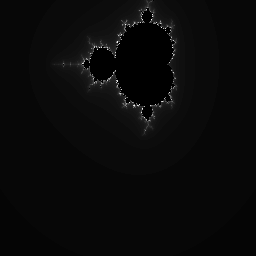
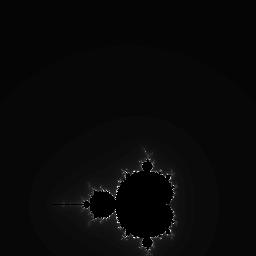
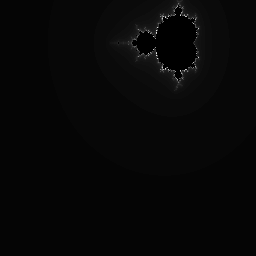
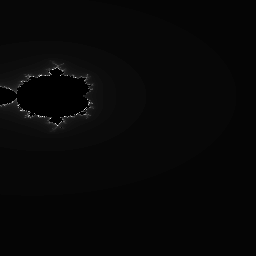
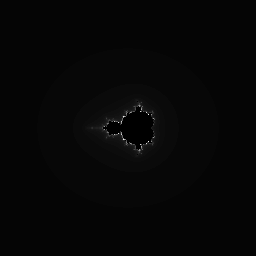
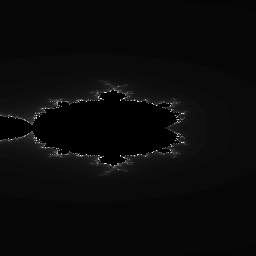
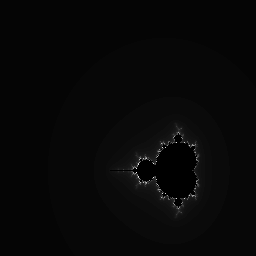
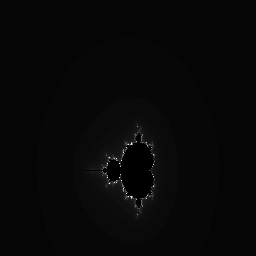
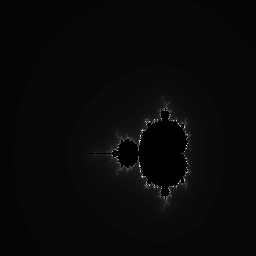
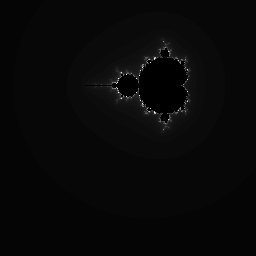
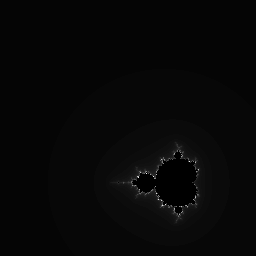
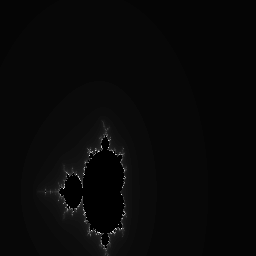
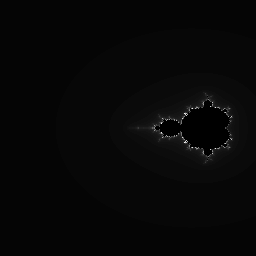
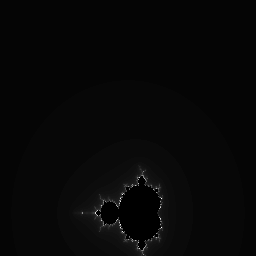
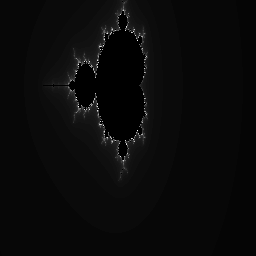
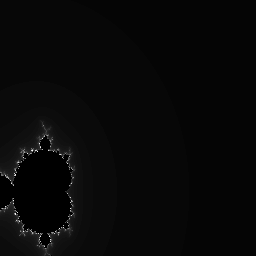
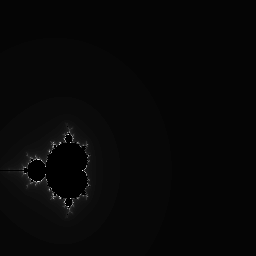
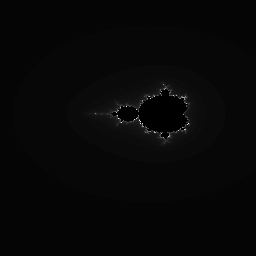
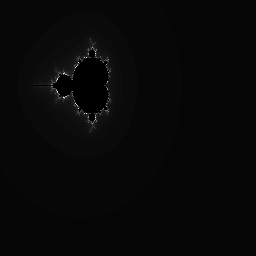
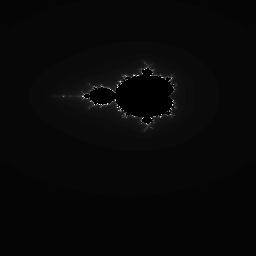
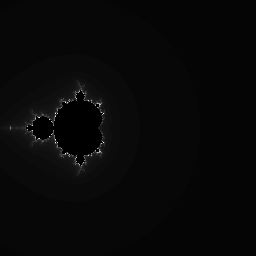
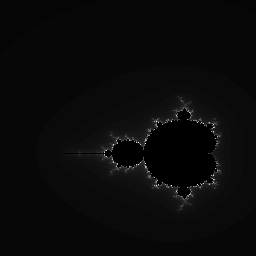
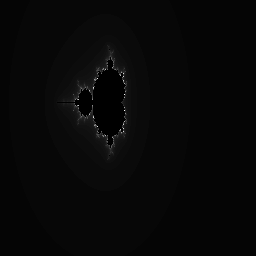
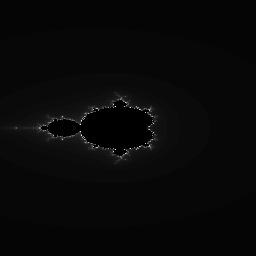
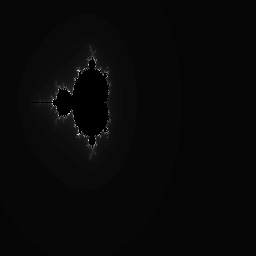
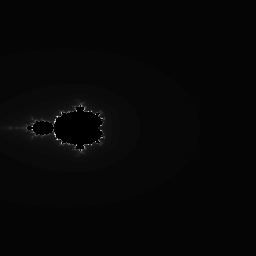
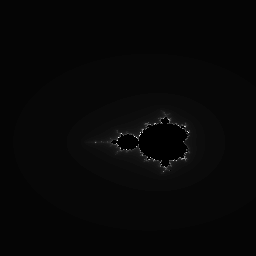
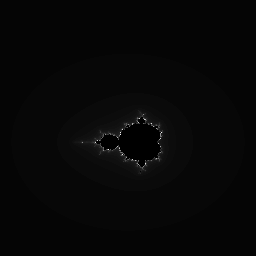
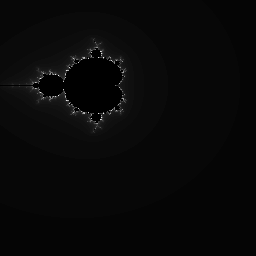
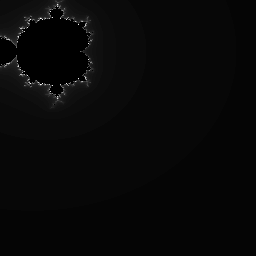
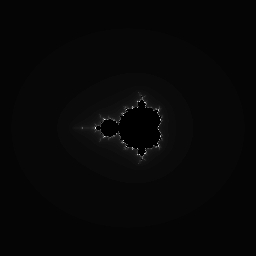
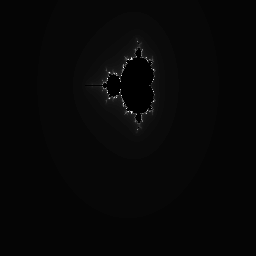
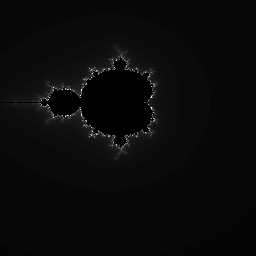
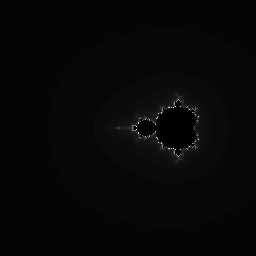
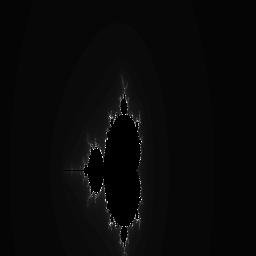
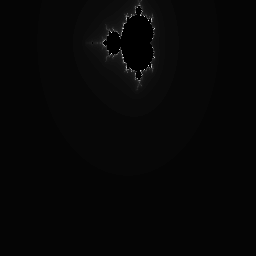
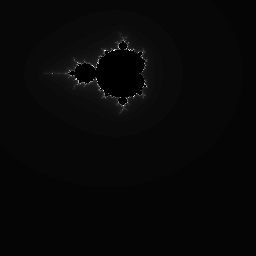
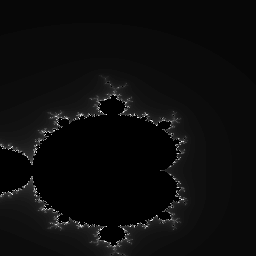
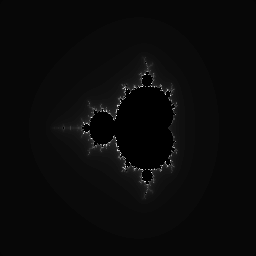
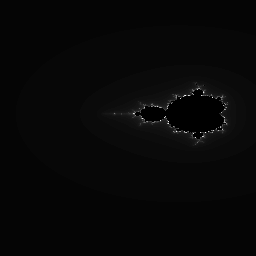

(RayWhylogsImgBinProfileExpActor pid=1130, ip=10.224.2.170) =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
(RayWhylogsImgBinProfileExpActor pid=1130, ip=10.224.2.170) median
(RayWhylogsImgBinProfileExpActor pid=1130, ip=10.224.2.170) <whylogs.core.datatypes.Integral object at 0x7fabb3cdbc40>
(RayWhylogsImgBinProfileExpActor pid=1130, ip=10.224.2.170) ColumnSchema(dtype=dtype('int64'), cfg=ImageMetricConfig(hll_lg_k=12, kll_k=256, fi_lg_max_k=10, fi_disabled=False, track_unicode_ranges=False, large_kll_k=True, kll_k_large=1024, unicode_ranges={'emoticon': (128512, 128591), 'control': (0, 31), 'digits': (48, 57), 'latin-upper': (65, 90), 'latin-lower': (97, 122), 'basic-latin': (0, 127), 'extended-latin': (128, 687)}, lower_case=True, normalize=True, max_frequent_item_size=128, identity_column=None, allowed_exif_tags=set(), forbidden_exif_tags=set()), type_mapper=<whylogs.core.datatype

In [57]:
if __name__=="__main__":
    try:
        #Initialize the RAY cluster
        ray.init(address="ray://kuberay-head-svc.kuberay:10001", ignore_reinit_error=True)

        main_exp()
    except Exception as error:
        print(traceback.format_exc())

## conclusion

In conclusion, we have orchestrated a robust and versatile framework, leveraging distributed system architecture, to facilitate image logging within our system. This architectural foundation, enhanced by the sophistication of our RAY Actor class, empowers developers to effortlessly manage and integrate image data.

By employing the intuitive log_image() function, we have bridged the gap between image logging and distributed system dynamics, offering a seamless and developer-friendly experience. This approach not only simplifies the process of working with image data but also unlocks the full potential of our system for a wide range of applications.

As we continue to advance and refine our architecture, we remain committed to providing developers with the tools and capabilities needed to tackle complex challenges in the ever-evolving landscape of data analysis and machine learning. With this framework in place, we look forward to new possibilities and innovations on the horizon